Importy Bibloitek

In [74]:
import json
import string
import os
import morfeusz2

import itertools as it
import operator as op
import pandas as pd
import numpy as np

from wordcloud import WordCloud
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from matplotlib import pyplot as plt

# Odkomentować przy odtwarzaniu środowiska Python
# import nltk
# nltk.download("punkt_tab")

1. Utworzenie korpusu dokumentów

In [75]:
corpus_dir = "./literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()

2. Wstepne przygotowanie dokumentów (preprocessing)

In [76]:
documents = dict()

for file_name in files:
    documents[file_name] = corpus.raw(file_name)

with open("./stopwords_pl.txt", "r", encoding="UTF-8") as stoplist_file:
    stoplist = stoplist_file.read()

stoplist = stoplist.splitlines()
stoplist = stoplist[4:]

def lemmatize(text: str):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0, 1))

    def disambiguate(group):
        pairs = ((len(descr), lemma) for _, _, (_, lemma,descr, _, _) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    
    lemmas = (disambiguate(group) for _, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language="polish") if word not in stoplist])

3. Utworzenie macierzy częstości

In [77]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']

count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])

tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])

4. Chmury tagów

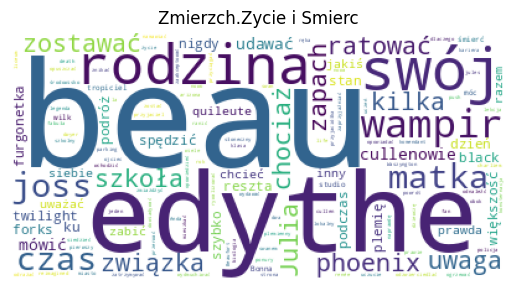

In [78]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5_000,
    contour_width=3,
    contour_color='steelblue')

if not os.path.exists("./chmury"):
    os.mkdir("./chmury")

for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))


5. Topic modelling

In [79]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")

def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}.png")
    plt.close()

In [80]:
def plot_documents(model, counts, files_names, n_components, title):
  colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange']
  docs_topics = pd.DataFrame(model.transform(counts), columns=[f"Topic {x}" for x in range(n_components)])
  docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
  plt.figure(figsize=(7,4))
  left = [0] * len(docs_topics)
  for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
  plt.savefig(f"./tematy/{title}_docs.png")
  plt.close()

In [81]:
n_components = 3
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
subplots = (1,3)

In [82]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)

lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA", subplots=subplots)
plot_documents(lda, counts_tf, files, n_components, "Tematy w modelu LDA")

In [83]:
nmf_fm = NMF(
    n_components=n_components,
    random_state=1, 
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF (FM)", subplots=subplots)
plot_documents(nmf_fm, counts_tfidf, files, n_components, "Tematy w modelu NMF (FM)")

In [84]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1, 
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu NMF (KL)", subplots=subplots)
plot_documents(nmf_kl, counts_tfidf, files, n_components, "Tematy w modelu NMF (KL)")

6. Analiza skupień

In [85]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [86]:
if not os.path.exists("./skupienia"):
    os.mkdir("./skupienia")

In [87]:
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(20,20)

In [88]:
clusering = AgglomerativeClustering(
    n_clusters=6,
    metric="euclidean",
    linkage="ward",
    compute_distances=True
).fit(cs)
clusering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 5, 4, 4, 0, 0, 0, 0, 2, 2, 2, 2, 3])

In [89]:
plot_dendrogram(
    clusering,
    labels = files,
    truncate_mode = 'level',
    orientation = 'left'
)
plt.savefig("./skupienia/cosine_ward.png")
plt.close()

In [90]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(20,20)
ed

array([[  0.        , 121.27654349, 134.6922418 , 142.95453823,
        131.791502  , 140.45995871, 133.9664137 , 130.7402004 ,
        168.95265609, 171.86913626, 176.79083687, 168.46364593,
        165.47507365, 169.07690558, 168.2111768 , 170.07351352,
        169.54055562, 168.6475615 , 170.37311995, 169.34875258],
       [121.27654349,   0.        ,  81.65782265,  84.05950273,
         73.53230583, 103.72559954,  85.17628778,  72.38093672,
        108.14342329, 122.18428704, 129.2091328 , 107.60111524,
        109.85444916, 108.73361946, 108.15266987, 114.58184848,
        113.19893992, 110.06361797, 111.69153952, 111.41364369],
       [134.6922418 ,  81.65782265,   0.        ,  59.09314681,
         65.99242381,  94.20721841,  65.12296062,  69.70652767,
         73.31439149,  94.6625586 , 104.89518578,  73.52550578,
         75.8419409 ,  74.00675645,  73.61385739,  84.05355436,
         81.62107571,  76.8635154 ,  78.35177088,  78.75912646],
       [142.95453823,  84.05950273,  

In [91]:
clusering = AgglomerativeClustering(
    n_clusters=6,
    metric="precomputed",
    linkage="complete",
    compute_distances=True
).fit(ed)
clusering.labels_

array([3, 5, 2, 2, 2, 4, 2, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [92]:
plot_dendrogram(
    clusering,
    labels = files,
    truncate_mode = 'level',
    orientation = 'right'
)
plt.savefig("./skupienia/euclidean_complete.png")
plt.close()

7. N-gramy

In [93]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))  

{
    "Harry Potter i Czara Ognia.txt": [
        "lord",
        "voldemort",
        "wraz",
        "sługa",
        "glizdogonem",
        "przybywać",
        "dom",
        "należący",
        "niegdyś",
        "rodzina",
        "riddleów",
        "położony",
        "little",
        "hangleton",
        "układać",
        "plan",
        "dotyczyć",
        "zamordować",
        "harryego",
        "pottera",
        "mieć",
        "pomóc",
        "czarny",
        "odzyskanie",
        "dawny",
        "moc",
        "mowa",
        "wierna",
        "sługa",
        "czarny",
        "wkrótce",
        "mieć",
        "znaleźć",
        "hogwarcie",
        "słyszeć",
        "mieszkać",
        "nieopodal",
        "ogrodnik",
        "frank",
        "bryka",
        "voldemort",
        "odkrywać",
        "mężczyzna",
        "podsłuchiwać",
        "zapraszać",
        "środek",
        "uśmiercać",
        "Harry",
        "budzić",
        "przerażający",
        

In [94]:
if not os.path.exists("./ngramy"):
    os.mkdir("./ngramy")

n_count = 3

if not os.path.exists(f"./ngramy/{n_count}"):
    os.mkdir(f"./ngramy/{n_count}")

for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], n_count)).value_counts()
    n_gram[:5].plot.barh()
    plt.savefig(f"./ngramy/{n_count}/{title.replace('.txt', '.png')}")
    plt.close()

In [95]:
texts = ' '.join(docs['content']).split(" ")
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.savefig(f"./ngramy/all.png")
plt.close()